#### 1. DATA LOADING, CLEANING & STANDARDIZATION 🧹

In [ ]:
# GOAL:
# Load the raw LD50 dataset, perform initial cleaning and standardize formats.
#
# KEY DIFFERENCES FROM PAPER:
#   - ENDPOINT: We are using acute toxicity (LD50), whereas the paper models POD.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_excel("/content/drive/MyDrive/data/final_database_temporary1.xlsx")

# Select only a subset of the dataset
df = df[["CASRN", "Species_Scientific_Name", "Qualifier", "LD50_value_mg/kg bw"]]

# Standardize column names
df.columns = df.columns.str.lower()
df = df.rename(columns={'species_scientific_name': 'species',
                        'ld50_value_mg/kg bw': 'ld50'})

# Standardize text in the 'species' column
df['species'] = df['species'].str.lower()
df['species'] = df['species'].replace({'anas platyrhnchos': 'anas platyrhynchos'})

# Sort the DF by 'casrn'
df = df.sort_values(by='casrn').reset_index(drop=True)

# Create a new column with log10(LD50)
df['log10'] = np.log10(df['ld50'])

# Impute missing values
df['species'] = df['species'].fillna('unknown species')
df['qualifier'] = df['qualifier'].fillna('=')

# Drop rows with no ld50 value
df = df.dropna(subset=['ld50'])

#### 2. EXPERIMENTAL UNCERTAINTY & DATASET COMPARISON 🔬

In [ ]:
# GOAL:
# Filter for exact measurements + create a replicate dataset for uncertainty and,
# another without replicates for modeling, and calculate the theoretical RMSE floor.
#
# DATA USED:
#   - From this point forward, the analysis will use ONLY exact measurements
#     (where 'qualifier' are '=, ~' & '>=, > 2000').
#
# FORMULA:
#   - Theoretical RMSE Floor = mean(std(chem_1), std(chem_2), ...), calculated
#     "only for chemicals with 2 or more measurements".

# Filter for exact measurements
df_exact = df[
    (df['qualifier'].isin(['=', '~'])) |
    ((df['qualifier'].isin(['>=', '>'])) & (df['ld50'] == 2000))
].copy()

# Create a separate, temporary dataframe for uncertainty analysis
df_replicates = df_exact.groupby('casrn').filter(lambda x: len(x) >= 2).copy()

# Create per-chemical dataset with statistics using only chemicals with replicates
chemicals_with_replicates = df_replicates.groupby("casrn")["log10"].agg([
    "count", "std", "median",
    lambda x: x.max() - x.min()
]).round(3)
chemicals_with_replicates.columns = ["count", "std", "median", "range"]

# Calculate theoretical RMSE floor
replicates = chemicals_with_replicates[chemicals_with_replicates["count"] >= 2]
theoretical_rmse_floor = replicates["std"].mean()

# Print dataset summary metrics for comparison
# IMPORTANT: Now print stats for the full "df_exact" dataset
print(f"{'Toxicity measurements':<30} {len(df_exact):<10} {'71020':<15}")
print(f"{'Unique chemicals':<30} {df_exact['casrn'].nunique():<10} {'3632':<15}")
print(f"{'Species diversity':<30} {df_exact['species'].nunique():<10} {'3':<15}")
print("\nEXPERIMENTAL UNCERTAINTY")
print("–" * 57)
print(f"{'Chemicals with replicates':<30} {len(replicates):<10} {'3632':<15}")
print(f"{'Theoretical RMSE floor':<30} {theoretical_rmse_floor:.2f}{'':<6} {'0.50':<15}")
print(f"{'Max per-chemical range (log10)':<30} {replicates['range'].max():.1f}{'':<6}  {'4.0':<15}")

Toxicity measurements          974        71020          
Unique chemicals               559        3632           
Species diversity              43         3              

EXPERIMENTAL UNCERTAINTY
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Chemicals with replicates      225        3632           
Theoretical RMSE floor         0.21       0.50           
Max per-chemical range (log10) 3.3        4.0            


#### 3. DESCRIPTOR LOADING & CLEANING 🧹

In [ ]:
# GOAL:
# Load the generated PubChem fingerprints, PaDEL descriptors, and CDK
# descriptors. Clean each set by removing invalid columns and redundant
# features, then report the counts at each stage.
#
# KEY DIFFERENCES FROM PAPER:
#   - CLEANING STRATEGY: To preserve our smaller set of chemicals, we drop
#     descriptor columns with invalid values. The paper dropped chemical 'rows'.
#   - CDK DESCRIPTORS: The paper started with a pre-selected set of 18 CDK
#     descriptors. We begin with all 223 calculable CDK descriptors.

# Load descriptor datasets
fp_df = pd.read_csv("/content/drive/MyDrive/data/results/fp.csv")
padel_df = pd.read_csv("/content/drive/MyDrive/data/results/padel.csv")
cdk_df = pd.read_csv("/content/drive/MyDrive/data/results/cdk.csv")

# --- Initial Descriptor Count Comparison ---
print(f"{'Type':<15} {'Ours (Initial)':<20} {'Pradeep et al.':<15}")
print("–" * 52)
print(f"{'Fingerprints':<15} {len(fp_df.columns) - 1:<20} {'881':<15}")
print(f"{'PaDEL':<15} {len(padel_df.columns) - 1:<20} {'1444':<15}")
print(f"{'CDK':<15} {len(cdk_df.columns) - 1:<20} {'18':<15}")

# --- Cleaning Process ---
# Store initial counts for the summary
fp_initial = len(fp_df.columns) - 1
padel_initial = len(padel_df.columns) - 1
cdk_initial = len(cdk_df.columns) - 1

# 1. Drop columns with NaN or Inf values from each descriptor set
for temp_df in [fp_df, padel_df, cdk_df]:
    temp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    temp_df.dropna(axis=1, inplace=True)

fp_after_nan = len(fp_df.columns) - 1
padel_after_nan = len(padel_df.columns) - 1
cdk_after_nan = len(cdk_df.columns) - 1

# 2. Drop CDK descriptors that are duplicates of PaDEL descriptors
overlapping_cols = set(cdk_df.columns) & set(padel_df.columns)
overlapping_cols.discard('casrn') # Ensure 'casrn' is not dropped
cdk_df.drop(columns=list(overlapping_cols), inplace=True)

cdk_after_duplicates = len(cdk_df.columns) - 1

# Cleaning Summary
print("\nDESCRIPTOR CLEANING SUMMARY:")
print(f"Fingerprints: {fp_initial} initial features -> {fp_after_nan} after dropping invalid columns")
print(f"PaDEL:        {padel_initial} initial features -> {padel_after_nan} after dropping invalid columns")
print(f"CDK:          {cdk_initial} initial features -> {cdk_after_nan} after dropping invalid columns -> {cdk_after_duplicates} after removing duplicates")

Type            Ours (Initial)       Pradeep et al. 
––––––––––––––––––––––––––––––––––––––––––––––––––––
Fingerprints    881                  881            
PaDEL           1444                 1444           
CDK             223                  18             

DESCRIPTOR CLEANING SUMMARY:
Fingerprints: 881 initial features -> 881 after dropping invalid columns
PaDEL:        1444 initial features -> 608 after dropping invalid columns
CDK:          223 initial features -> 181 after dropping invalid columns -> 121 after removing duplicates


#### 4. FEATURE SELECTION (REPLICATING THE PAPER'S METHOD) 🎯

In [ ]:
!pip install feature_engine -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
# GOAL:
# Reduce descriptors using the paper's method and then assemble a single,
# aligned DataFrame called `modeling_df`. This master DataFrame will contain
# the chemical identifier ('casrn'), all selected features (X), and the
# median log10(LD50) target (y) for each chemical.
#
# METHODOLOGY:
#   - FINGERPRINTS (Binary): Remove low-variance (>80% constant) and
#     highly correlated (Pearson's r > 0.8) features.
#   - NUMERICAL (PaDEL & CDK): Standardize the data, then use Recursive
#     Feature Elimination (RFE) with a Linear Regression estimator to
#     select the top 5 most predictive features from each set.

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures

# Create the per-chemical summary from the FULL exact dataset for modeling
chemicals = df_exact.groupby("casrn")["log10"].agg(['median']).round(3)

# --- 1. Prepare Target and Align with Descriptors ---

# Create a DataFrame for the selection target (median log10 LD50 per chemical)
selection_target_df = chemicals[['median']].reset_index()

# Align feature sets with the target by merging
fp_aligned = fp_df.merge(selection_target_df, on='casrn', how='inner')
padel_aligned = padel_df.merge(selection_target_df, on='casrn', how='inner')
cdk_aligned = cdk_df.merge(selection_target_df, on='casrn', how='inner')


# --- 2. Fingerprint Selection ---

# Separate the features from the identifier ('casrn') and target ('median')
fingerprint_features = fp_aligned.drop(columns=['casrn', 'median'])

# Remove features that are constant for >80% of the chemicals
constant_remover = DropConstantFeatures(tol=0.8)
fp_varied = constant_remover.fit_transform(fingerprint_features)

# Remove features that are highly correlated (r > 0.8)
correlated_remover = DropCorrelatedFeatures(threshold=0.8)
fp_selected_features = correlated_remover.fit_transform(fp_varied)

# Re-attach the 'casrn' identifier to the selected fingerprint features
fp_selected = pd.concat([fp_aligned[['casrn']], fp_selected_features], axis=1)


# --- 3. Numerical Descriptor Selection (PaDEL & CDK) ---

# --- PaDEL ---
# Separate features (X) from the target (y) for the selection algorithm
padel_features = padel_aligned.drop(columns=['casrn', 'median'])
padel_target = padel_aligned['median']

scaler = StandardScaler()
padel_features_scaled = scaler.fit_transform(padel_features)

rfe_padel = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe_padel.fit(padel_features_scaled, padel_target)
padel_selected_cols = padel_features.columns[rfe_padel.support_]

# Re-attach the 'casrn' identifier to the selected PaDEL features
padel_selected = pd.concat([padel_aligned[['casrn']], padel_features[padel_selected_cols]], axis=1)

# --- CDK ---
# Separate features (X) from the target (y)
cdk_features = cdk_aligned.drop(columns=['casrn', 'median'])
cdk_target = cdk_aligned['median']

scaler = StandardScaler()
cdk_features_scaled = scaler.fit_transform(cdk_features)

rfe_cdk = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe_cdk.fit(cdk_features_scaled, cdk_target)
cdk_selected_cols = cdk_features.columns[rfe_cdk.support_]

# Re-attach the 'casrn' identifier to the selected CDK features
cdk_selected = pd.concat([cdk_aligned[['casrn']], cdk_features[cdk_selected_cols]], axis=1)


# --- 4. Assemble Final Per-Chemical Modeling DataFrame ---

# Sequentially merge all selected feature sets and the target into a single DataFrame
X_features = fp_selected.merge(padel_selected, on='casrn', how='inner') \
                        .merge(cdk_selected, on='casrn', how='inner')

modeling_df = X_features.merge(selection_target_df, on='casrn', how='inner')

# --- 5. Final Comparison and Summary ---
print("--- SELECTED FEATURE COUNT COMPARISON ---")
print(f"{'Descriptor Type':<15} {'Ours (Selected)':<20} {'Pradeep et al.':<15}")
print("–" * 52)
print(f"{'Fingerprints':<15} {len(fp_selected.columns) - 1:<20} {'38'}")
print(f"{'PaDEL':<15} {len(padel_selected.columns) - 1:<20} {'5'}")
print(f"{'CDK':<15} {len(cdk_selected.columns) - 1:<20} {'5'}")

print(f"\nShape of the final features DataFrame (X_features): {X_features.shape} (unique chemicals)")

--- SELECTED FEATURE COUNT COMPARISON ---
Descriptor Type Ours (Selected)      Pradeep et al. 
––––––––––––––––––––––––––––––––––––––––––––––––––––
Fingerprints    59                   38
PaDEL           5                    5
CDK             5                    5

Shape of the final features DataFrame (X_features): (545, 70) (unique chemicals)


#### 5. PREPARING DATASETS FOR MODELING ⚙️

In [ ]:
# GOAL:
# Prepare two distinct datasets and their corresponding train/test splits.
# This setup is required to replicate the paper's comparison between their
# simple 'ALL' model and their final, more complex '*ALL' model.
#
# DATASET 1 (for 'ALL' replication): A 'per-chemical grouping'.
#   - STRUCTURE: One row per chemical.
#   - TARGET (y): The overall median log10(LD50) for that chemical.
#   - FEATURES (X): Only the selected chemical descriptors.
#
# DATASET 2 (for '*ALL' replication): A 'per-chemical-species grouping'.
#   - STRUCTURE: One row per unique chemical-species pair.
#   - TARGET (y): The median log10(LD50) for that specific pair.
#   - FEATURES (X): Chemical descriptors PLUS the encoded species.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# --- 1. Prepare Data for Model 1 (Per-Chemical Grouping) ---
print("--- Preparing Dataset 1 (Per-Chemical Grouping) ---")

# This dataset uses the overall median LD50 per chemical from Cell 4.
X_per_chem = modeling_df.drop(columns=['casrn', 'median'])
y_per_chem = modeling_df['median']

# Create the 80/20 train/test split for this dataset
X_chem_train, X_chem_test, y_chem_train, y_chem_test = train_test_split(
    X_per_chem, y_per_chem, test_size=0.20, random_state=42
)
print(f"Shapes: X_train={X_chem_train.shape}, X_test={X_chem_test.shape}")


# --- 2. Prepare Data for Model 2 (Per-Chemical-Species Grouping) ---
print("\n--- Preparing Dataset 2 (Per-Chemical-Species Grouping) ---")

# Calculate the median LD50 for each unique chemical-species pair
toxicity_per_species = df_exact.groupby(['casrn', 'species']) \
                         .agg(median_log10_ld50=('log10', 'median')) \
                         .reset_index()


# Merge with the selected chemical features
data_per_species = pd.merge(toxicity_per_species, X_features, on='casrn', how='inner')

# Add 'species_code' as a predictive feature
encoder = OrdinalEncoder()
data_per_species['species_code'] = encoder.fit_transform(data_per_species[['species']])

# Define features (X) and target (y)
X_per_species = data_per_species.drop(columns=['casrn', 'species', 'median_log10_ld50'])
y_per_species = data_per_species['median_log10_ld50']

# Create the 80/20 train/test split for this second dataset
X_species_train, X_species_test, y_species_train, y_species_test = train_test_split(
    X_per_species, y_per_species, test_size=0.20, random_state=42
)
print(f"Shapes: X_train={X_species_train.shape}, X_test={X_species_test.shape}")

--- Preparing Dataset 1 (Per-Chemical Grouping) ---
Shapes: X_train=(436, 69), X_test=(109, 69)

--- Preparing Dataset 2 (Per-Chemical-Species Grouping) ---
Shapes: X_train=(630, 70), X_test=(158, 70)


#### 6. TRAINING & EVALUATING MODELS 🌳

In [ ]:
# GOAL:
# Train and evaluate the two models using the datasets prepared in Cell 5.
# The performance of each model is then compared in separate tables against
# its corresponding counterpart from the Pradeep et al. paper.
#
# MODEL 1 (Per-Chemical): Replicates the paper's simpler 'ALL' model.
# MODEL 2 (Per-Species): Replicates the paper's final '*ALL' model.

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Define a single hyperparameter grid for both Random Forest models
param_grid = {
    'n_estimators': [750, 1000, 1500],
    'max_features': ['sqrt', 1.0],
    'random_state': [42]
}

# --- 1. Train and Evaluate Model 1 (Per-Chemical Grouping) ---

# Set up and train the Grid Search on the per-chemical data
grid_search1 = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search1.fit(X_chem_train, y_chem_train)
best_rf1 = grid_search1.best_estimator_

# Get cross-validated training scores
y_chem_train_pred = cross_val_predict(best_rf1, X_chem_train, y_chem_train, cv=5)
r2_chem_train = r2_score(y_chem_train, y_chem_train_pred)
rmse_chem_train = np.sqrt(mean_squared_error(y_chem_train, y_chem_train_pred))

# Get test scores
y_chem_test_pred = best_rf1.predict(X_chem_test)
r2_chem_test = r2_score(y_chem_test, y_chem_test_pred)
rmse_chem_test = np.sqrt(mean_squared_error(y_chem_test, y_chem_test_pred))


# --- 2. Train and Evaluate Model 2 (Per-Chemical-Species Grouping) ---

# Set up and train the Grid Search on the per-species data
grid_search2 = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search2.fit(X_species_train, y_species_train)
best_rf2 = grid_search2.best_estimator_

# Get cross-validated training scores
y_species_train_pred = cross_val_predict(best_rf2, X_species_train, y_species_train, cv=5)
r2_species_train = r2_score(y_species_train, y_species_train_pred)
rmse_species_train = np.sqrt(mean_squared_error(y_species_train, y_species_train_pred))

# Get test scores
y_species_test_pred = best_rf2.predict(X_species_test)
r2_species_test = r2_score(y_species_test, y_species_test_pred)
rmse_species_test = np.sqrt(mean_squared_error(y_species_test, y_species_test_pred))


# --- 3. Display Performance Comparison Tables ---

print("\n--- MODEL 1 (Per-Chemical Grouping) vs. Paper 'ALL' ---")
print(f"{'Metric':<12} {'Ours':<15} {'Paper':<15}")
print("–" * 45)
print(f"{'R² Train':<12} {r2_chem_train:<15.2f} {'0.32'}")
print(f"{'RMSE Train':<12} {rmse_chem_train:<15.2f} {'0.82'}")
print(f"{'R² Test':<12} {r2_chem_test:<15.2f} {'0.36'}")
print(f"{'RMSE Test':<12} {rmse_chem_test:<15.2f} {'0.81'}")

print("\n--- MODEL 2 (Per-Chemical-Species Grouping) vs. Paper '*ALL' ---")
print(f"{'Metric':<12} {'Ours':<15} {'Paper':<15}")
print("–" * 45)
print(f"{'R² Train':<12} {r2_species_train:<15.2f} {'0.54'}")
print(f"{'RMSE Train':<12} {rmse_species_train:<15.2f} {'0.67'}")
print(f"{'R² Test':<12} {r2_species_test:<15.2f} {'0.57'}")
print(f"{'RMSE Test':<12} {rmse_species_test:<15.2f} {'0.70'}")


--- MODEL 1 (Per-Chemical Grouping) vs. Paper 'ALL' ---
Metric       Ours            Paper          
–––––––––––––––––––––––––––––––––––––––––––––
R² Train     0.35            0.32
RMSE Train   0.58            0.82
R² Test      0.35            0.36
RMSE Test    0.59            0.81

--- MODEL 2 (Per-Chemical-Species Grouping) vs. Paper '*ALL' ---
Metric       Ours            Paper          
–––––––––––––––––––––––––––––––––––––––––––––
R² Train     0.62            0.54
RMSE Train   0.54            0.67
R² Test      0.77            0.57
RMSE Test    0.42            0.70



--- Table 2 Replication: Top 10 Most Important Features (Model 2) ---


,Feature,Importance (%)
0,species_code,8.87%
1,khs.dsssP,5.98%
2,ATSp2,5.74%
3,ATSp3,5.69%
4,SpMax_Dt,5.14%
5,EE_D,5.05%
6,SpMax_D,4.97%
7,EE_Dt,4.94%
8,SPC-6,4.75%
9,SPC-4,4.06%


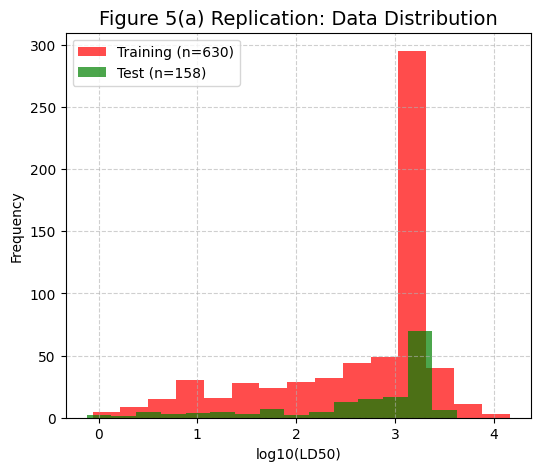

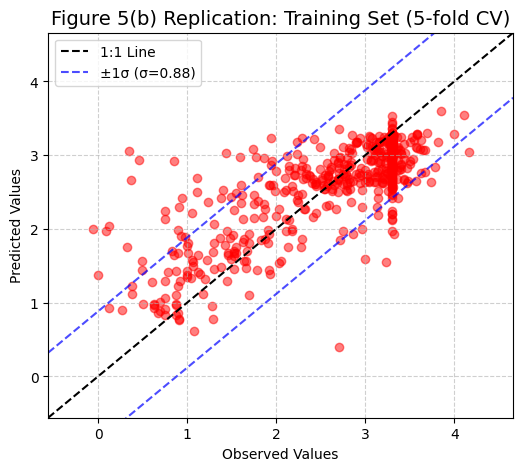

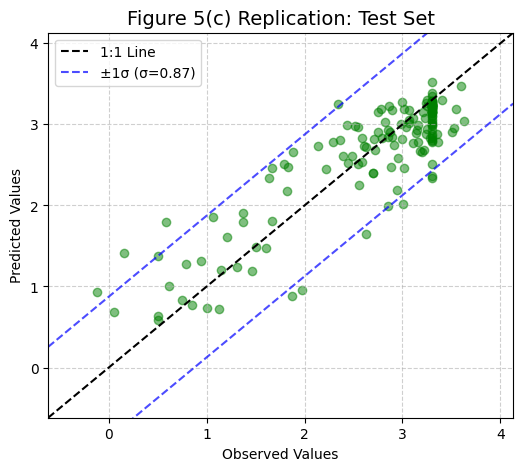

In [ ]:
# --- Table 2 Replication: Top 10 Most Important Features ---
# Extract feature importances and convert to percentages.
feature_importances = pd.DataFrame({
    'Feature': X_species_train.columns,
    'Importance': best_rf2.feature_importances_
}).sort_values('Importance', ascending=False).head(10).reset_index(drop=True)

feature_importances['Importance (%)'] = feature_importances['Importance'] * 100

print("\n--- Table 2 Replication: Top 10 Most Important Features (Model 2) ---")
display(feature_importances[['Feature', 'Importance (%)']].style.format({'Importance (%)': '{:.2f}%'}))

# --- Figure 5(a) Replication: Data Distribution ---
# This plot shows the distribution of toxicity values in the training and test sets.
plt.figure(figsize=(6, 5))
plt.hist(y_species_train, bins=15, color='red', alpha=0.7, label=f'Training (n={len(y_species_train)})')
plt.hist(y_species_test, bins=15, color='green', alpha=0.7, label=f'Test (n={len(y_species_test)})')
plt.title("Figure 5(a) Replication: Data Distribution", fontsize=14)
plt.xlabel("log10(LD50)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# --- Figure 5(b) Replication: Training Set (5-fold CV) Performance ---
# This plot compares the cross-validated predicted values to the observed values.
plt.figure(figsize=(6, 5))
plt.scatter(y_species_train, y_species_train_pred, alpha=0.5, color='red')

# Define axis limits for the 1:1 and error lines
min_val = min(y_species_train.min(), y_species_train_pred.min()) - 0.5
max_val = max(y_species_train.max(), y_species_train_pred.max()) + 0.5
sigma_train = y_species_train.std()

# Add 1:1 line and ±1-sigma error interval lines
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')
plt.plot([min_val, max_val], [min_val + sigma_train, max_val + sigma_train], 'b--', alpha=0.7, label=f'±1σ (σ={sigma_train:.2f})')
plt.plot([min_val, max_val], [min_val - sigma_train, max_val - sigma_train], 'b--', alpha=0.7)

plt.title("Figure 5(b) Replication: Training Set (5-fold CV)", fontsize=14)
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


# --- Figure 5(c) Replication: Test Set Performance ---
# This plot compares the predicted values to the observed values on unseen data.
plt.figure(figsize=(6, 5))
plt.scatter(y_species_test, y_species_test_pred, alpha=0.5, color='green')

# Define axis limits for the 1:1 and error lines
min_val = min(y_species_test.min(), y_species_test_pred.min()) - 0.5
max_val = max(y_species_test.max(), y_species_test_pred.max()) + 0.5
sigma_test = y_species_test.std()

# Add 1:1 line and ±1-sigma error interval lines
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')
plt.plot([min_val, max_val], [min_val + sigma_test, max_val + sigma_test], 'b--', alpha=0.7, label=f'±1σ (σ={sigma_test:.2f})')
plt.plot([min_val, max_val], [min_val - sigma_test, max_val - sigma_test], 'b--', alpha=0.7)

plt.title("Figure 5(c) Replication: Test Set", fontsize=14)
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

#### 7. ENRICHMENT ANALYSIS 📈

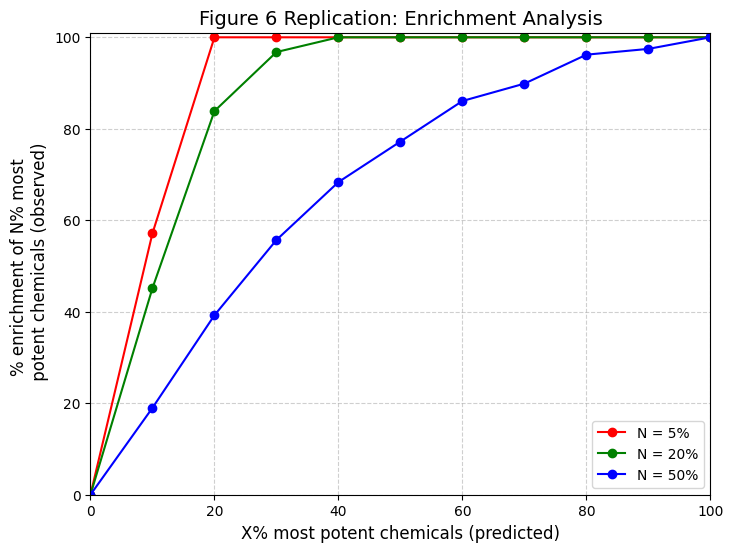

In [ ]:
# GOAL:
# Evaluate the model's ability to prioritize the most potent chemicals by
# replicating the enrichment analysis shown in Figure 6 of the paper.
# This is a key metric for a model intended for screening purposes.
#
# METHODOLOGY:
#   - Chemicals in the test set are ranked by both their observed (true) and
#     predicted toxicity values (lower LD50 = more potent).
#   - We then plot the percentage of the top N% most potent *observed* chemicals
#     that are successfully captured within the top X% most potent *predicted*
#     chemicals.
#   - This is repeated for N = 5%, 20%, and 50%.
#
# KEY DIFFERENCES FROM PAPER:
#   - This analysis is performed on our smaller LD50 test set. The resulting
#     curves will reflect the performance on our specific data and may differ
#     in shape from the paper's, which was based on a large POD dataset.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_enrichment_curve(y_true, y_pred, n_percent):
    """Calculates the enrichment curve for a given N%."""
    # Create a dataframe with true and predicted values
    df = pd.DataFrame({'true': y_true, 'pred': y_pred})

    # Rank chemicals by potency (lower LD50 value is more potent)
    df['rank_true'] = df['true'].rank(pct=True) # pct=True normalizes ranks to 0-1
    df['rank_pred'] = df['pred'].rank(pct=True)

    # Identify the set of top N% truly potent chemicals
    top_n_true = set(df[df['rank_true'] <= (n_percent / 100)].index)

    # Define the x-axis for the plot
    x_axis_percentages = np.arange(0, 101, 10)
    y_axis_enrichment = []

    # For each X%, calculate the enrichment
    for x_percent in x_axis_percentages:
        if not top_n_true: # Avoid division by zero if N% is too small for the dataset
             y_axis_enrichment.append(0)
             continue

        # Identify the set of top X% predicted potent chemicals
        top_x_pred = set(df[df['rank_pred'] <= (x_percent / 100)].index)

        # Find the intersection (chemicals in both sets)
        intersection = top_n_true.intersection(top_x_pred)

        # Calculate enrichment as a percentage
        enrichment = len(intersection) / len(top_n_true) * 100
        y_axis_enrichment.append(enrichment)

    return y_axis_enrichment

# --- Calculate the three enrichment curves using Model 2's test set predictions ---
x_axis = np.arange(0, 101, 10)
y_curve_5 = calculate_enrichment_curve(y_species_test, y_species_test_pred, 5)
y_curve_20 = calculate_enrichment_curve(y_species_test, y_species_test_pred, 20)
y_curve_50 = calculate_enrichment_curve(y_species_test, y_species_test_pred, 50)


# --- Generate the Enrichment Plot ---
plt.figure(figsize=(8, 6))

# Plot each curve, matching the paper's style
plt.plot(x_axis, y_curve_5, 'o-', color='red', label='N = 5%')
plt.plot(x_axis, y_curve_20, 'o-', color='green', label='N = 20%')
plt.plot(x_axis, y_curve_50, 'o-', color='blue', label='N = 50%')

# Set titles and labels to match the paper
plt.title("Figure 6 Replication: Enrichment Analysis", fontsize=14)
plt.ylabel("% enrichment of N% most \n potent chemicals (observed)", fontsize=12)
plt.xlabel("X% most potent chemicals (predicted)", fontsize=12)

# Set axis limits and add grid/legend
plt.xlim(0, 100)
plt.ylim(0, 101)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

#### 8. BOOTSTRAP CONFIDENCE INTERVAL MODEL 🔄

In [ ]:
# GOAL:
# Implement the paper's second modeling approach to provide predictions with a
# 95% confidence interval, which helps to quantify model uncertainty.
#
# METHODOLOGY:
#   - 100 separate Random Forest models are trained using the same optimal
#     hyperparameters found for Model 2.
#   - For each model, the training target (y_train) is slightly altered by
#     adding random noise (std = 0.50), replicating the paper's method.
#   - The final prediction is the mean of all 100 model predictions. The
#     95% confidence interval (CI) is calculated as ±2 standard deviations
#     of those predictions.

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm # For a progress bar

# --- 1. Define Bootstrap Parameters ---
n_models = 100
noise_sigma = 0.50 # Using the fixed value from the paper
best_params = grid_search2.best_params_

# --- 2. Run Bootstrap Loop ---
# A list is used to collect predictions from each of the 100 models.
prediction_runs = []

for i in tqdm(range(n_models), desc="Training Bootstrap Models"):
    # Create a noisy version of the training target data
    y_train_noisy = y_species_train + np.random.normal(loc=0.0, scale=noise_sigma, size=len(y_species_train))

    # Initialize and train a new model on the noisy data
    model = RandomForestRegressor(**best_params)
    model.fit(X_species_train, y_train_noisy)

    # Make predictions and append them to our list
    prediction_runs.append(model.predict(X_species_test))

# Convert the list of predictions into a 2D array and transpose it
# Shape becomes (n_chemicals, n_models)
all_test_predictions = np.array(prediction_runs).T


# --- 3. Calculate Final Predictions and Confidence Intervals ---
y_test_pred_mean = np.mean(all_test_predictions, axis=1)
y_test_pred_std = np.std(all_test_predictions, axis=1)
# The 95% CI is the value on one side of the mean (mean ± CI)
ci_95 = 2 * y_test_pred_std


# --- 4. Evaluate and Report Results ---
r2_bootstrap = r2_score(y_species_test, y_test_pred_mean)
rmse_bootstrap = np.sqrt(mean_squared_error(y_species_test, y_test_pred_mean))

print("\n--- BOOTSTRAP MODEL PERFORMANCE (TEST SET) ---")
print(f"{'Metric':<15} {'Ours':<15} {'Paper'}")
print("–" * 45)
print(f"{'R² Score':<15} {r2_bootstrap:<15.2f} {'0.53'}")
print(f"{'RMSE':<15} {rmse_bootstrap:<15.2f} {'0.72'}")
# [cite_start]The paper's discussion notes the CI width approaches ±1.0 log units [cite: 349]
print(f"{'Avg. 95% CI (±)':<15} {np.mean(ci_95):<15.2f} {'~1.00'}")


# --- 5. Display Sample Predictions with Confidence Intervals ---
# Create a DataFrame to show example predictions with their final range.
results_df = pd.DataFrame({
    'Observed LD50': y_species_test.values,
    'Predicted LD50 (Mean)': y_test_pred_mean,
    'Lower 95% CI': y_test_pred_mean - ci_95,
    'Upper 95% CI': y_test_pred_mean + ci_95,
})

# Create a formatted string for the final range
results_df['95% CI Range'] = results_df.apply(
    lambda row: f"[{row['Lower 95% CI']:.2f} – {row['Upper 95% CI']:.2f}]", axis=1
)

print("\n--- SAMPLE BOOTSTRAP PREDICTIONS ---")
display(results_df[['Observed LD50', 'Predicted LD50 (Mean)', '95% CI Range']].head(10).style.format({
    'Observed LD50': '{:.2f}',
    'Predicted LD50 (Mean)': '{:.2f}',
}))

Training Bootstrap Models:   0%|          | 0/100 [00:00<?, ?it/s]


--- BOOTSTRAP MODEL PERFORMANCE (TEST SET) ---
Metric          Ours            Paper
–––––––––––––––––––––––––––––––––––––––––––––
R² Score        0.77            0.53
RMSE            0.42            0.72
Avg. 95% CI (±) 0.44            ~1.00

--- SAMPLE BOOTSTRAP PREDICTIONS ---
